In [1]:
# Importing the libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

from sklearn.feature_extraction.text import TfidfVectorizer
import sklearn.preprocessing
from wordcloud import WordCloud, STOPWORDS

# Read Data

In [2]:
data = pd.read_csv(r'../DATA/2.BookTopics_Cleaned.csv')
data.head(2)

,ISBN,BookName,Authors,Published,Price,Topic,SubTopic,TopicNo,SubTopicNo,SearchTag,Source,Link,Name_Topic_SubTopic,TopicKeywords,SubTopicKeywords
0,9781789807974.0,blockchain quick start guide,"['Xun (Brian) Wu, Weimin Sun']",December 2018,199.09,introduction to blockchain technology,introduction to blockchain technology,1.0,1.0,Blockchain,PacktPub,NaN,blockchain quick start guide introduction to b...,blockchain technology,blockchain technology
1,9781789807974.0,blockchain quick start guide,"['Xun (Brian) Wu, Weimin Sun']",December 2018,199.09,introduction to blockchain technology,the consensus mechanism,1.0,3.0,Blockchain,PacktPub,NaN,blockchain quick start guide introduction to b...,blockchain technology,consensus mechanism


Following are subjects for which user can search for

In [3]:
data.SearchTag.unique()

array(['Blockchain', 'DeepLearning', nan, 'Data Mining', 'Databases',
       'Hadoop', 'InternetOfThings', 'MachineLearning', 'Neo4J',
       'NaturalLanguageProcessing', 'Python', 'Spark', 'Statistics',
       'visualization', 'LinearAlgebra', 'ExcelDataAnalysis', 'Tableau',
       'QlikSense', 'SQL', 'DataAnalysis'], dtype=object)

###### Enter Subject Name that you want to study

In [4]:
SubjectName='MachineLearning' # please match the exact Subject name with above Search Tags
TopicListLength=10


In [5]:
BooksDF=data[data['SearchTag']==SubjectName].reset_index(drop=True)
BooksDF.head()

,ISBN,BookName,Authors,Published,Price,Topic,SubTopic,TopicNo,SubTopicNo,SearchTag,Source,Link,Name_Topic_SubTopic,TopicKeywords,SubTopicKeywords
0,9781788992282.0,hands-on machine learning for cybersecurity,"['Soma Halder, Sinan Ozdemir']",December 2018,199.13,chapter 1: basics of machine learning in cyber...,what is machine learning?,1.0,1.0,MachineLearning,PacktPub,NaN,handson machine learning for cybersecurity cha...,basics machine learning cyber security,machine learning
1,9781788992282.0,hands-on machine learning for cybersecurity,"['Soma Halder, Sinan Ozdemir']",December 2018,199.13,chapter 2: time series analysis and ensemble l...,what is time series?,2.0,1.0,MachineLearning,PacktPub,NaN,handson machine learning for cybersecurity cha...,time series analysis ensemble learning,time series
2,9781788992282.0,hands-on machine learning for cybersecurity,"['Soma Halder, Sinan Ozdemir']",December 2018,199.13,chapter 2: time series analysis and ensemble l...,what is time series analysis ?,2.0,2.0,MachineLearning,PacktPub,NaN,handson machine learning for cybersecurity cha...,time series analysis ensemble learning,time series analysis
3,9781788992282.0,hands-on machine learning for cybersecurity,"['Soma Halder, Sinan Ozdemir']",December 2018,199.13,chapter 2: time series analysis and ensemble l...,stationarity of a time series models,2.0,3.0,MachineLearning,PacktPub,NaN,handson machine learning for cybersecurity cha...,time series analysis ensemble learning,stationarity time series models
4,9781788992282.0,hands-on machine learning for cybersecurity,"['Soma Halder, Sinan Ozdemir']",December 2018,199.13,chapter 2: time series analysis and ensemble l...,strictly stationary process,2.0,4.0,MachineLearning,PacktPub,NaN,handson machine learning for cybersecurity cha...,time series analysis ensemble learning,strictly stationary process


# Cleaning
## Removing Stopwords from Topics




In [ ]:
english_stops = stopwords.words('english')
english_stops.extend(['part','chapter','introduction'])
english_stops.extend([':','?'])

In [ ]:
# used vector programming instead of for loop

BooksDF['TopicKeywords'] = BooksDF.Topic.fillna('').str.replace('[0-9]+','').apply(lambda rowX:[topicWord for topicWord in rowX.split() if topicWord.lower() not in english_stops])
BooksDF['TopicKeywords']=BooksDF['TopicKeywords'].apply(lambda rowX:' '.join(rowX)) 
BooksDF[['TopicKeywords','TopicNo']].head()

# Topic Number Scaling

Each book has different different Topic Index Length

For example Book A has 10 Topics and Book B has 20 Topics.<br>
And normaly the first topic of any book is Basic ( or essential/important) and last topic of any book is Advance (less important)

Accourding to above assumption,<br>
<b>For Book A :</b> 10th Topic is Advance (Less Needed) <br>
<b>For Book B :</b> 10th Topic is the middle topic. And 20th Topic is Advance.

So we need to normalized all the Topics between 1 to 10 (given on users choice, how lengthy he wants to see index)

In [6]:
TopicListLength

10

In [7]:
mms=sklearn.preprocessing.MinMaxScaler(feature_range=(1,TopicListLength))

tempDF=pd.DataFrame()
BooksDF['ScaledTopicNo']=-1 #for some reason. Had some problem in Joins
BackupDF=BooksDF

In [8]:
BooksDF=BackupDF

for grp in BooksDF.groupby(by=['ISBN']):
        
    scaled=pd.DataFrame(mms.fit_transform(grp[1]['TopicNo'].values.reshape(-1,1)),columns=['TempScaledTopicNo'])
    tempDF=pd.concat([grp[1][['ISBN','TopicNo','SubTopicNo']].reset_index(drop=True),scaled],axis=1)
    BooksDF=pd.merge(BooksDF,tempDF, on=['ISBN','TopicNo','SubTopicNo'], how='left')
    
    
    # Need to do following things. Otherwise new rows keep increasing . eg. TempScaledTopicNo_x,TempScaledTopicNo_y
    BooksDF.loc[BooksDF.TempScaledTopicNo>BooksDF.ScaledTopicNo,'ScaledTopicNo'] = BooksDF.loc[BooksDF.TempScaledTopicNo>BooksDF.ScaledTopicNo,'TempScaledTopicNo']
    BooksDF.drop(columns=['TempScaledTopicNo'],inplace=True)



In [9]:
BooksDF.head()

,ISBN,BookName,Authors,Published,Price,Topic,SubTopic,TopicNo,SubTopicNo,SearchTag,Source,Link,Name_Topic_SubTopic,TopicKeywords,SubTopicKeywords,ScaledTopicNo
0,9781788992282.0,hands-on machine learning for cybersecurity,"['Soma Halder, Sinan Ozdemir']",December 2018,199.13,chapter 1: basics of machine learning in cyber...,what is machine learning?,1.0,1.0,MachineLearning,PacktPub,NaN,handson machine learning for cybersecurity cha...,basics machine learning cyber security,machine learning,1.0
1,9781788992282.0,hands-on machine learning for cybersecurity,"['Soma Halder, Sinan Ozdemir']",December 2018,199.13,chapter 2: time series analysis and ensemble l...,what is time series?,2.0,1.0,MachineLearning,PacktPub,NaN,handson machine learning for cybersecurity cha...,time series analysis ensemble learning,time series,5.5
2,9781788992282.0,hands-on machine learning for cybersecurity,"['Soma Halder, Sinan Ozdemir']",December 2018,199.13,chapter 2: time series analysis and ensemble l...,what is time series analysis ?,2.0,2.0,MachineLearning,PacktPub,NaN,handson machine learning for cybersecurity cha...,time series analysis ensemble learning,time series analysis,5.5
3,9781788992282.0,hands-on machine learning for cybersecurity,"['Soma Halder, Sinan Ozdemir']",December 2018,199.13,chapter 2: time series analysis and ensemble l...,stationarity of a time series models,2.0,3.0,MachineLearning,PacktPub,NaN,handson machine learning for cybersecurity cha...,time series analysis ensemble learning,stationarity time series models,5.5
4,9781788992282.0,hands-on machine learning for cybersecurity,"['Soma Halder, Sinan Ozdemir']",December 2018,199.13,chapter 2: time series analysis and ensemble l...,strictly stationary process,2.0,4.0,MachineLearning,PacktPub,NaN,handson machine learning for cybersecurity cha...,time series analysis ensemble learning,strictly stationary process,5.5


# TFIDF

Now we will give word frequency to each word according to Rank.

Since each has words like learning , method. We sould penalize the common words.
<br>Lets find words which are exclusive for that Rank.

In [10]:
OnlyIndexDF=BooksDF[BooksDF.TopicKeywords.isna()==False].sort_values(by='ScaledTopicNo')[['ScaledTopicNo','TopicKeywords']]

# Topics are redundant due to subtopics inside. Therefore we will drop duplicate
OnlyIndexDF.drop_duplicates(inplace=True)
OnlyIndexDF.reset_index(drop=True,inplace=True)



In [11]:
OnlyIndexDF.head()

,ScaledTopicNo,TopicKeywords
0,1.0,basics machine learning cyber security
1,1.0,machine learning
2,1.0,welcome machine learning using .net framework
3,1.0,thinking machine learning
4,1.0,applied machine learning quick start


In [12]:
# Cross-check : It should be between 1 to 10 (Fraction number)
set(OnlyIndexDF.ScaledTopicNo)

{1.0,
 1.0633802816901408,
 1.1267605633802817,
 1.1901408450704225,
 1.2000000000000002,
 1.2535211267605635,
 1.3169014084507042,
 1.3214285714285716,
 1.3461538461538463,
 1.380281690140845,
 1.4285714285714284,
 1.443661971830986,
 1.4500000000000002,
 1.473684210526316,
 1.5,
 1.5070422535211268,
 1.5294117647058822,
 1.5625,
 1.5704225352112675,
 1.6,
 1.6338028169014085,
 1.6428571428571428,
 1.642857142857143,
 1.692307692307692,
 1.6923076923076923,
 1.6971830985915493,
 1.75,
 1.76056338028169,
 1.8181818181818183,
 1.823943661971831,
 1.857142857142857,
 1.8873239436619718,
 1.9,
 1.9473684210526316,
 1.9507042253521125,
 1.9642857142857144,
 2.0,
 2.0140845070422535,
 2.0384615384615383,
 2.058823529411765,
 2.0774647887323945,
 2.125,
 2.140845070422535,
 2.1999999999999997,
 2.204225352112676,
 2.267605633802817,
 2.2857142857142856,
 2.285714285714286,
 2.3309859154929575,
 2.35,
 2.384615384615384,
 2.3846153846153846,
 2.3943661971830985,
 2.4,
 2.4210526315789473,
 2.

In [13]:
OnlyIndexDF.ScaledTopicNo=OnlyIndexDF.ScaledTopicNo.apply(np.floor)

# Cross-check : It should be between 1 to 10 (integer number)
set(OnlyIndexDF.ScaledTopicNo)

{1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0}

In [14]:
# Here we are combine all topics under 1 Rank. So if there 10 distinct Ranks. So 10 entries


CombineLines=[]
RankTitle=[]
for grp in OnlyIndexDF.groupby('ScaledTopicNo'):
    #print(grp[0])
    #print(grp[1]['TopicKeywords'])
    CombineLines.append(' \n '.join(grp[1]['TopicKeywords']))
    RankTitle.append(grp[0])

    


In [15]:
RankTitle=list(map(int,RankTitle)) # float to int type cast


##### CROSS CHECK #####

print(RankTitle)
print(len(CombineLines))

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
10


In [16]:
# Take a look at 0th class..
print('Rank : ',RankTitle[0])
CombineLines[0]

Rank :  1


'basics machine learning cyber security \n machine learning \n welcome machine learning using .net framework \n thinking machine learning \n applied machine learning quick start \n spark machine learning \n process success \n introducing probability theory \n introducing test-driven machine learning \n welcome age information technology \n scala machine learning \n unsupervised machine learning \n python machine learning ecosystem \n practical machine learning using python \n tensorflow – basic concepts \n first steps scalability \n big data data science – \n data analytics spark \n exploratory data analysis \n working strings \n realm supervised learning \n fundamentals machine learning \n premodel workflow \n transforming data actions \n working matrices \n instant weka how-to \n introducing machine learning \n machine learning – gentle \n mahout difficult! \n getting running spark \n introducing apache mahout \n giving computers ability learn data \n getting started recommender syst

limit_output extension: Maximum message size of 10000 exceeded with 10466 characters

## Creating Tokens

As of now will only take Bigrams. 

But <b>WE SHOULD TRY UNIGRAM,TRIGRAM AND NGRAM</b> in future

### Unigrams, Bigrams, Trigrams

In [17]:
vocabListTemp=[]
#for l in OnlyIndexDF['TopicKeywords'].str.lower():
for l in OnlyIndexDF['TopicKeywords'].str.lower():
    nltk_tokens=nltk.word_tokenize(l)
    vocabListTemp.extend(nltk_tokens) #uni
    vocabListTemp.extend(list(nltk.bigrams(nltk_tokens))) #bi
    vocabListTemp.extend(list(nltk.trigrams(nltk_tokens))) #tri

vocabList=[]
for tup in vocabListTemp:
    if(type(tup)==str):# unigram
        vocabList.append(tup)
    else:
        vocabList.append(' '.join(tup))


vocabList=set(vocabList)

In [18]:
vocabList 
# this we have to do bcoz of problem of machine learning \n linear regression => gives => learning linear bigram in TFIDF inbuild function

# so will restrict this kind of features by vocabList


{'revisited true error',
 'working graph',
 'higherorder',
 'networks hidden markov',
 'information granules fundamental',
 'fit tests',
 'filters inferential',
 'momentum',
 'microsoft azure stack',
 'interface ( api',
 'bayes classification using',
 'information mining',
 'minimum crossentropy method',
 'learning best',
 'univariate unbinned goodness',
 'aerospace industry companies',
 'versus reward –',
 'trading market microstructure',
 'engineering nlp algorithms',
 'true predictive marketing',
 'bandit reinforcement learning',
 '( sbe )',
 'web (',
 'skills',
 'troubleshooting industrial',
 'facial detection',
 'bagging',
 'adapting machine',
 'convexity',
 'identity',
 'learning made easier',
 'weighted graph',
 'monte carlo',
 'models –',
 'improvement -',
 'financial services company',
 'convergence random',
 'find',
 'sensing mobile cognitive',
 'terrarium revisited',
 'boosting multifactor',
 'representations',
 'facial motion',
 'detection prevention',
 'dimensionality redu

limit_output extension: Maximum message size of 10000 exceeded with 21713 characters

In [19]:
#vocabList.remove('machine learning')# removing subject name itself

In [20]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(stop_words='english',ngram_range=(1,3))
vectorizer.fixed_vocabulary_=True
vectorizer.vocabulary=vocabList
X = vectorizer.fit_transform(CombineLines)
TokenFreqDF=pd.DataFrame(X.toarray(),columns=vectorizer.get_feature_names())

In [21]:
TokenFreqDF=pd.concat([pd.DataFrame(RankTitle,columns=['Rank']),TokenFreqDF],axis=1)

In [22]:
TokenFreqDF

,Rank,!,! challenge,! challenge (,! prediction,! prediction takes,#,# .net,# x,# x ;,...,– traveling,– traveling salesman,– tree,"– tree ,",– two,– two datasets,– validating,– validating results,– what,– what 's
0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,10,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [23]:
uniCols=TokenFreqDF.columns[TokenFreqDF.columns.str.count(' ')==0] # Unigrams
biCols=TokenFreqDF.columns[TokenFreqDF.columns.str.count(' ')==1] # Bigrams
triCols=TokenFreqDF.columns[TokenFreqDF.columns.str.count(' ')==2] # Trigrams


# we will give high weitage to trigrams, then bigram, after unigram



In [24]:
TokenFreqDF[triCols]=TokenFreqDF[triCols]*4
TokenFreqDF[biCols]=TokenFreqDF[biCols]*3.5
TokenFreqDF[uniCols]=TokenFreqDF[uniCols]*1

In [25]:
TokenFreqDF

,Rank,!,! challenge,! challenge (,! prediction,! prediction takes,#,# .net,# x,# x ;,...,– traveling,– traveling salesman,– tree,"– tree ,",– two,– two datasets,– validating,– validating results,– what,– what 's
0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,10,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Above tables seems 0s every where. Lets check wether above table has any non zero value

In [26]:
##### CROSS CHECK #####

TokenFreqDF[TokenFreqDF.Rank==1].T[TokenFreqDF.T[0]>0.1].to_dict()

{0: {'Rank': 1.0,
  'basics machine': 0.12998870460882853,
  'basics machine learning': 0.14855851955294688,
  'big data': 0.10528000875659851,
  'bootstrap error': 0.17331827281177134,
  'classification rules': 0.12998870460882853,
  'crossvalidation error': 0.12998870460882853,
  'crossvalidation error bootstrap': 0.14855851955294688,
  'data': 0.13731271313144838,
  'data analytics': 0.11050227468276469,
  'data science': 0.14325379394172374,
  'distribution theory': 0.12998870460882853,
  'error': 0.5156772818529018,
  'error bootstrap': 0.17331827281177134,
  'error bootstrap error': 0.19807802607059583,
  'error crossvalidation': 0.12998870460882853,
  'error crossvalidation error': 0.14855851955294688,
  'error estimation': 0.38996611382648555,
  'error leaveoneout': 0.30330697742059987,
  'error leaveoneout error': 0.34663654562354274,
  'error rates': 0.3466365456235427,
  'error rates true': 0.19807802607059583,
  'error resubstitution': 0.17331827281177134,
  'error resubsti

In [27]:
#CanDo

# More weightage to trigrams

# Result

In [28]:
# Below is the function to get topic (key name) which has maximum score (values)

def GetKeyWithMaxValue(dic,excludeList): # exclude list will make sure that we are not repeating topic
    mostCommonTopic=max(dic, key=dic.get)
    
    while(mostCommonTopic in excludeList):
        dic.pop(mostCommonTopic)
        mostCommonTopic=max(dic, key=dic.get)
    return mostCommonTopic


In [29]:
topicList=[] # This is the final TopicList i.e. ans of our problem statement
# initiat topicList everytime before using 

stopwordList=set([])

In [30]:
# Plot WordCloud and get the Topic Which has max TFIDF Score

def GetFrequentTopic(n=1): # 1 to n

    row=TokenFreqDF[TokenFreqDF.Rank==n]
    rowDict=row.drop(columns='Rank').T.to_dict()[n-1]

    wordcloud = WordCloud(stopwords=stopwordList).generate_from_frequencies(rowDict)
    wordcloud.background_color='pink'
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.show()

    mostCommonTopic=GetKeyWithMaxValue(rowDict,topicList)
    topicList.append(mostCommonTopic)
    print(n,mostCommonTopic)

In [31]:
def GetFrequentTopic_NoPlot(n=1): # 1 to n

    row=TokenFreqDF[TokenFreqDF.Rank==n]
    rowDict=row.drop(columns='Rank').T.to_dict()[n-1]

    mostCommonTopic=GetKeyWithMaxValue(rowDict,topicList)
    topicList.append(mostCommonTopic)
    print(n,mostCommonTopic)

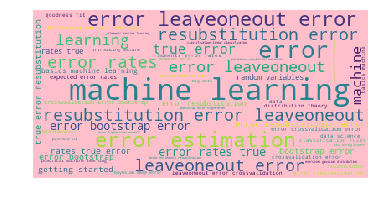

1 machine learning


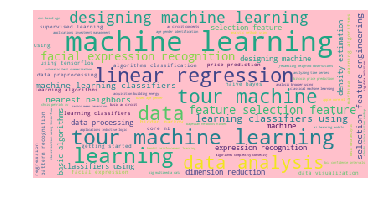

2 tour machine learning


In [32]:
topicList=[]

GetFrequentTopic(1)
GetFrequentTopic(2)

# Lets automate this

In [33]:
topicList=[]
for i in range(1,TopicListLength+1):
    GetFrequentTopic_NoPlot(i)

1 machine learning
2 tour machine learning
3 naive bayes
4 learning
5 logistic regression
6 neural networks
7 natural language processing
8 deep learning
9 modeling spam detection
10 creating machine learning


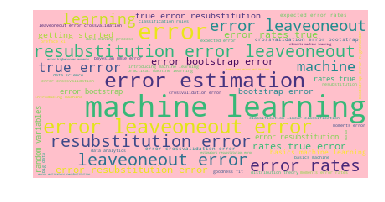

1 machine learning


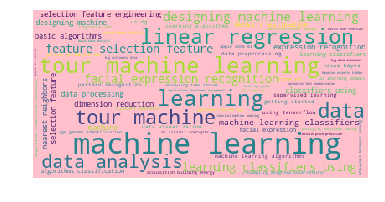

2 tour machine learning


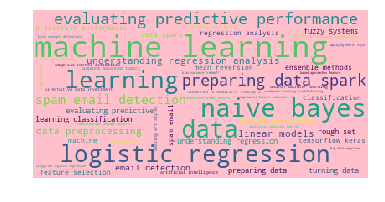

3 naive bayes


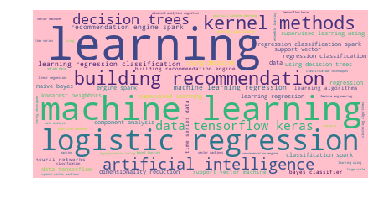

4 learning


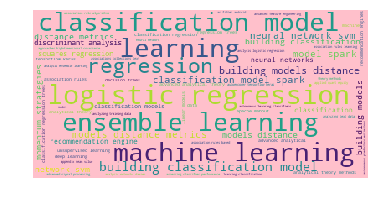

5 logistic regression


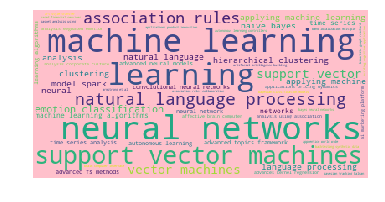

6 neural networks


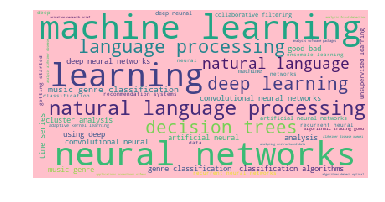

7 natural language processing


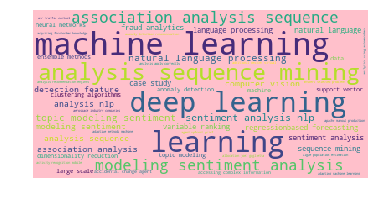

8 deep learning


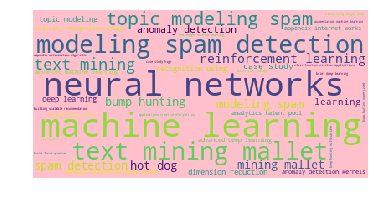

9 modeling spam detection


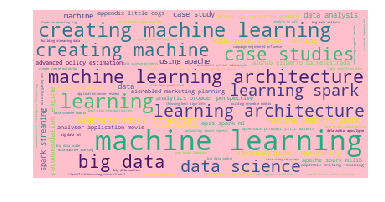

10 creating machine learning


In [34]:
topicList=[]
for i in range(1,TopicListLength+1):
    GetFrequentTopic(i)

In [35]:
topicList

['machine learning',
 'tour machine learning',
 'naive bayes',
 'learning',
 'logistic regression',
 'neural networks',
 'natural language processing',
 'deep learning',
 'modeling spam detection',
 'creating machine learning']

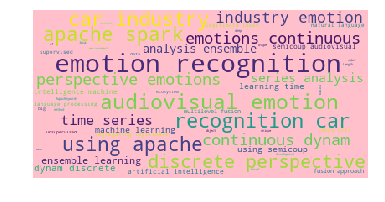

In [38]:




wordcloud = WordCloud(stopwords=stopwordList).generate(str(BooksDF.TopicKeywords.unique))
wordcloud.background_color='pink'
plt.imshow(wordcloud)
plt.axis("off")
plt.show()


# Done

In [37]:
# ---------- XOXOXOXOXO ----------- #

In [46]:


from io import BytesIO
import base64




# Sub Topic List